### Importing all libraries

In [49]:
#Importing audio file paths
import os

#For managing dataframe
import pandas as pd
import numpy as np

#PyTorch
import torchaudio
import torch
from torch.utils.data import Dataset
from torch import nn

# Misc.
import multiprocessing # will be used for loading data using multipler workers (cpu_count)
import librosa
from sklearn.model_selection import train_test_split

#Selecting device
device="cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device}")

Using cuda


### Recursively get all audio files

In [2]:
def audio_fetch(src,audio_paths):
    l=os.listdir(src)
    if(len(l)!=0):
        for i in range(len(l)):
            if(".wav" in l[i] or ".mp3" in l[i] or ".aac" in l[i]):
                audio_paths.append(str(src+l[i]))
            elif("." not in l[i]):
                try:
                    audio_fetch(str(src+"/"+l[i]+"/"),audio_paths)
                except:
                    continue
                            
# For getting all possible classes along with their label encoding as a dictionary
def class_fetch(df: pd.DataFrame())->(list,dict):
    s=set(sorted(df[1].unique()))
    
    toDel=[i for i in dict(df[1].value_counts(sort=True)).keys() if dict(df[1].value_counts(sort=True))[i]<3]
    for i in toDel:
        s.remove(i)
    d={}
    
    toDel_ids=[]
    for i in toDel:
        toDel_ids.extend(list(df[df[1]==i][0].values))
    
    
    count=0
    for i in s:
        d[i]=count
        count+=1
    return list(s),d, toDel_ids

### Dataset Class

In [52]:
class audio_dataset(Dataset):
    def __init__(self,
                 info: str,
                 audio_path=None,
                 audio_files=None,
                 target_sample_rate=16000,
                 num_samples=320000,
                 transforms=None,
                 header=None) -> None:
        
        self.paths=[]

        if (audio_path==None and audio_files==None):
            raise Exception("Both audio_path and audio_files cannot be None at the same time")

        if(audio_files==None):
            audio_fetch(audio_path,self.paths)
        else:
            self.paths=audio_files

        self.transformation=transforms
        self.target_sample_rate=target_sample_rate
        self.target_samples=num_samples
        
        self.patient=dict()
        self.paths.sort() 
        
        # We are going to remove all classes than 2 patient data

        for i in self.paths:
            index=int(i.split("/")[-1].split("_")[0])
            self.patient[index]=[]
        
        for i in range(len(self.paths)):
            self.patient[int(self.paths[i].split("/")[-1].split("_")[0])].append(self.paths[i])
        
        self.info_df=pd.read_csv(info,header=header)
        self.classes, self.class_to_idx, self.ids_to_remove = class_fetch(self.info_df)

        # After getting the patient ids to remove all the data from patient list is removed
        for i in self.ids_to_remove:
            if i in self.patient.keys():
                self.patient.pop(i)

        #Denotes sequence of audio files for a particular patient
        self.sequence=list(self.patient.values())

        # Audio path is updated after removing classing with small number of patients
        self.paths=[]
        for i in self.sequence:
            if(i!=[]):
                for j in i:
                    self.paths.append(j)

    
    def get_class(self,file: str):
        return self.info_df[self.info_df[0]==int(file.split("/")[-1].split("_")[0])][1].values[0]


    # Necessary audio transformations: 
    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.target_samples:
            signal = signal[:, :self.target_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.target_samples:
            num_missing_samples = self.target_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    
    def __len__(self) -> int:
        return len(self.paths)


    def __getitem__(self, index: int) -> torch.Tensor():
        self.val=self.paths[index]
        self.class_val=self.class_to_idx[self.get_class(self.val)]

        self.signal, self.sr = torchaudio.load(self.val)
        self.signal = self._resample_if_necessary(self.signal, self.sr)
        self.signal = self._mix_down_if_necessary(self.signal)
        self.signal = self._cut_if_necessary(self.signal)
        self.signal = self._right_pad_if_necessary(self.signal)
        if(self.transformation!=None):
            self.signal = self.transformation(self.signal)

        return self.signal,self.class_val

##### Testing audio dataset

In [53]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=16000,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )

ds=audio_dataset(audio_path="../Sound_Classification/archive/Respiratory_Sound_Database/",info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv",transforms=mel_spectrogram)
ds.class_to_idx

{'Pneumonia': 0,
 'URTI': 1,
 'Healthy': 2,
 'Bronchiectasis': 3,
 'Bronchiolitis': 4,
 'COPD': 5}

In [54]:
print(len(ds.sequence))
print(ds.get_class(ds.paths[3]))

123
COPD


### Dataloader

In [55]:
BATCH_SIZE=4
NUM_WORKERS=multiprocessing.cpu_count()

ds=[]
audio_fetch("../Sound_Classification/archive/respiratory_sound_database/",ds)

# Perform train test split
train_ds,temp_ds=train_test_split(ds,test_size=0.4)
test_ds,val_ds=train_test_split(temp_ds,test_size=0.5)

print(f"Before trimming:")
print(f"No. of audio files in train_ds: {len(train_ds)}\nNo. of audio files in test_ds: {len(test_ds)}\nNo. of audio files in val_ds: {len(val_ds)}")

train_ds=audio_dataset(audio_files=train_ds,info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv",transforms=mel_spectrogram)
test_ds=audio_dataset(audio_files=test_ds,info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv",transforms=mel_spectrogram)
val_ds=audio_dataset(audio_files=val_ds,info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv",transforms=mel_spectrogram)

print(f"\nAfter trimming:")
print(f"No. of audio files in train_ds: {train_ds.__len__()}\nNo. of audio files in test_ds: {test_ds.__len__()}\nNo. of audio files in val_ds: {val_ds.__len__()}")

train_loader=torch.utils.data.DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS)
test_loader=torch.utils.data.DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS)
val_loader=torch.utils.data.DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS)

Before trimming:
No. of audio files in train_ds: 552
No. of audio files in test_ds: 184
No. of audio files in val_ds: 184

After trimming:
No. of audio files in train_ds: 550
No. of audio files in test_ds: 184
No. of audio files in val_ds: 183


##### Checking dataloader

/tmp/ipykernel_23326/3893681720.py:10: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=64).
  plt.specgram(im)


(array([[4.06605179e+05],
        [7.75414521e+05],
        [6.71313353e+05],
        [5.25484555e+05],
        [3.69575247e+05],
        [2.32866568e+05],
        [1.35097941e+05],
        [8.32006248e+04],
        [7.18633745e+04],
        [8.70442086e+04],
        [1.11257776e+05],
        [1.29143629e+05],
        [1.31606678e+05],
        [1.17256485e+05],
        [9.10033753e+04],
        [6.08401043e+04],
        [3.43449042e+04],
        [1.61707321e+04],
        [7.13624443e+03],
        [4.90705246e+03],
        [5.77703247e+03],
        [6.73407418e+03],
        [6.91622249e+03],
        [7.85272442e+03],
        [1.24709057e+04],
        [2.34301714e+04],
        [4.15960240e+04],
        [6.52988324e+04],
        [9.06074137e+04],
        [1.12439046e+05],
        [1.26071857e+05],
        [1.28541536e+05],
        [1.19472818e+05],
        [1.01102226e+05],
        [7.75375011e+04],
        [5.35533001e+04],
        [3.33334030e+04],
        [1.95222230e+04],
        [1.2

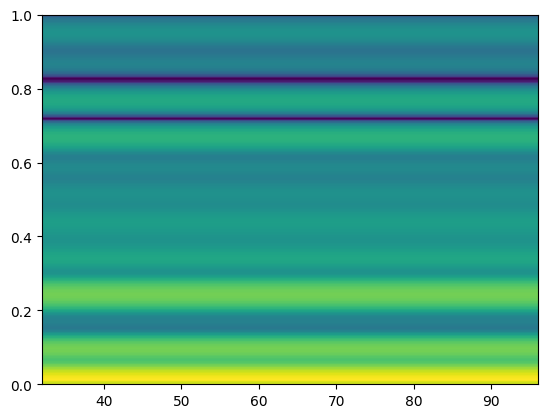

In [56]:
im=next(iter(train_loader))[0][0]
im=im.permute(1,2,0)

librosa.display.specshow(librosa.power_to_db(y,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')'''

import matplotlib.pyplot as plt
plt.specgram(im)

In [48]:
im.shape

torch.Size([64, 44, 1])

### Model

In [8]:
class auditory_transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_embedding=nn.Sequential(nn.BatchNorm1d(num_features=1),
                                           nn.Conv1d(in_channels=1,out_channels=128,kernel_size=3),
                                           nn.ReLU(),
                                           nn.BatchNorm1d(num_features=128),
                                           nn.Conv1d(in_channels=128,out_channels=256,kernel_size=3),
                                           nn.ReLU(),
                                           nn.BatchNorm1d(num_features=256),
                                           nn.Conv1d(in_channels=256,out_channels=512,kernel_size=3),
                                           nn.ReLU(),
                                           nn.BatchNorm1d(num_features=512),
                                           nn.Conv1d(in_channels=512,out_channels=1024,kernel_size=3),
                                           nn.ReLU(),
                                           nn.BatchNorm1d(num_features=1024),
                                           nn.Conv1d(in_channels=1024,out_channels=2048,kernel_size=3),
                                           nn.ReLU(),
                                           nn.BatchNorm1d(num_features=2048),
                                           nn.Conv1d(in_channels=2048,out_channels=4096,kernel_size=3))

    def forward(self,x):
        return self.input_embedding(x)

In [9]:
next(iter(train_loader))[0].shape

torch.Size([4, 1, 80000])

In [10]:
model=auditory_transformer().to(device)
with torch.inference_mode():
    model((next(iter(train_loader))[0]).to(device)).shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.88 GiB. GPU 0 has a total capacty of 5.80 GiB of which 3.07 GiB is free. Including non-PyTorch memory, this process has 2.71 GiB memory in use. Of the allocated memory 2.57 GiB is allocated by PyTorch, and 12.81 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
wv, sr=torchaudio.load(train_ds.paths[0])

In [ ]:
resmaple=torchaudio.transforms.Resample(torchaudio.load(train_ds.paths[0])[1],16000)

In [ ]:
resmaple(wv).shape

In [ ]:
model(next(iter(train_loader))[0].to(device))